<a href="https://colab.research.google.com/github/matheus97eng/Bootcamp_Alura_2021/blob/main/projeto_final/notebooks/analise_exploratoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação

Esse é um dos notbooks do projeto final de bootcamp de DataScience da Alura (2021). A intenção do projeto é criar um modelo de machine learning capaz de prever, com um certo nível de confiança, se um paciente que chega ao hospital precisará ser futuramente internado ou não. **Este notebook vai focar somente na exploração dos dados que serão utilizados no treinamento e teste do modelo.**

# Dados

Os dados são do hospital Sírio Libanês, que os disponibilizou pelo [kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) com o objetivo de procurar um modelo que prevesse da melhor maneira possível se um paciente com entrada no hospital precisaria ser internado ou não na UTI.

As informações foram retiradas do kaggle no mês de **Julho de 2021** e colocadas [nesse repositório](https://github.com/matheus97eng/Bootcamp_Alura_2021/blob/main/modulo-4/aulas/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx) do github.

In [1]:
import pandas as pd

data = pd.read_excel('https://github.com/matheus97eng/Bootcamp_Alura_2021/blob/main/modulo-4/aulas/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')
data.tail()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
1920,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.012346,-0.292308,0.056604,-0.525424,0.535714,0.789474,0.012346,-0.292308,0.056604,-0.517241,0.535714,0.789474,0.175258,-0.050,0.145299,-0.428571,0.714286,0.919192,-0.299145,-0.502703,-0.164179,-0.575758,0.246377,0.789474,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1921,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.717277,-0.717277,-0.717277,-0.717277,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.170732,-0.170732,-0.170732,-0.170732,-1.0,-0.982208,-0.982208,...,-0.979571,-1.0,0.086420,-0.384615,-0.113208,-0.593220,0.142857,0.578947,0.086420,-0.384615,-0.113208,-0.586207,0.142857,0.578947,0.237113,-0.125,-0.008547,-0.500000,0.472527,0.838384,-0.247863,-0.567568,-0.298507,-0.636364,-0.072464,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
1922,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.169811,-0.593220,0.142857,0.736842,0.086420,-0.230769,-0.169811,-0.586207,0.142857,0.736842,0.237113,0.000,-0.059829,-0.500000,0.472527,0.898990,-0.247863,-0.459459,-0.343284,-0.636364,-0.072464,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
1923,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.209877,-0.384615,-0.188679,-0.661017,0.285714,0.473684,0.209877,-0.384615,-0.188679,-0.655172,0.285714,0.473684,0.340206,-0.125,-0.076923,-0.571429,0.560440,0.797980,-0.162393,-0.567568,-0.358209,-0.696970,0.043478,0.473684,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0
1924,384,0,50th,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.983255,-0.983255,..

Descrição das colunas:

`PATIENT_VISIT_IDENTIFIER` = identificador do paciente, de 0 a 384, correspondendo a 385 pacientes no total.

`AGE_ABOVE65` = 0 para pacientes menores de 65 anos e 1 para maiores de 65 anos.

`AGE_PERCENTIL` = faixa etária do paciente

`GENDER` = 0 para homens e 1 para mulheres

`DISEASE GROUPING 1` - `DISEASE GROUPING 6` e `HTN` = ausencia (valor 0) de determinada doença no paciente ou então presença (valor 1). HTN significa hipertenção. Os outros tipos de doença não foram revelados por questões de privacidade.

`IMMUNOCOMPROMISED` - o paciente está imunocomprometido? 0 para não e 1 para sim.

obs.: um paciente imunocomprometido é aquele que possui o sistema imunológico comprometido e que não consegue fazer a defesa que o organismo precisa fazer para a pessoa não ficar doente.

`OTHER` = não é deixado claro pelo hospital, mas possivelmente é a presença ou ausência de uma doença não listada.

`ALBUMIN_MEDIAN` - `OXYGEN_SATURATION_DIFF_REL` = informações sobre testes sanguíneos e informações vitais do paciente. São divididos entre as colunas:
- `MEAN` = média do valor obtido durante a janela
- `MEDIAN` = mediana do valor obtido durante a janela
- `MIN` = mínimo
- `MAX` = máximo
- `DIFF` = diferença entre máximo e mínimo
- `DIFF_REL` = valor de `DIFF` dividido pela mediana

`WINDOW` - janela representando qual período que o paciente ficou no hospital:
- '0-2' = nas primeiras 2 horas
- '2-4' = entre 2 a 4 horas
- '4-6' = entre 4 a 6 horas
- '6-12' = entre 6 a 12 horas
- 'ABOVE_12' = acima de 12 horas

`ICU` = coluna que fornece a informação se o paciente foi para UTI (valor 1) ou não foi (valor 1).

# Objetivo

Estudando o dataset dado pelo hospital Sírio Libanês, este projeto deseja responder a algumas perguntas antes da realização do objetivo final:

1) Quais os pacientes que no final tiveram que ser internados e quais os que não?

2) Dentre os pacientes que precisaram ser internados, em algum momento houve um paciente que apresentou algum tipo de doença?

3) Dentre os pacientes internados, qual a média dos dados que o paciente apresentou *antes* dele ter ido para a UTI?

4) qual a diferença que o paciente ter ou não determinado tipo de doença faz no resultado dele ter sido internado ou não?

5) Pacientes imunocomprometidos correm alto risco de serem internados?



## 1) Quais os pacientes que no final tiveram que ser internados e quais os que não?

Começando com a primeira pergunta, sabemos que a coluna `ICU` contém os dados com exatamente essa informação: os valores `0` representam pacientes que não foram para UTI e os valores `1` os que precisaram ser internados. Vamos olhar em um gráfico como  alguns pacientes se comportaram quanto à internação ao longo das janelas de tempo.

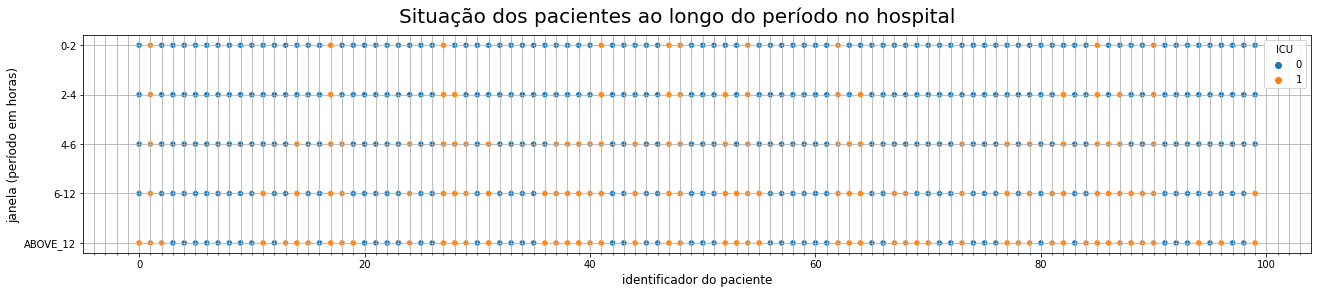

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(22,4))
ax = sns.scatterplot(data=data.iloc[:500], x='PATIENT_VISIT_IDENTIFIER', y='WINDOW', hue='ICU')

plt.suptitle('Situação dos pacientes ao longo do período no hospital', size=20)
plt.ylabel('janela (período em horas)', size=12)
plt.xlabel('identificador do paciente', size=12)

ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.grid()
plt.grid(which='minor')

No gráfico, os pontos laranjas indicam quando o paciente foi internado na UTI. Por questão de visualização, foram escolhidos somente os primeiros 100 pacientes, mas é possível ter uma ideia geral do quadro de pacientes do Sírio Libanês. Vamos verificar agora qual a porcentagem, no final dos períodos, de pacientes que precisaram ser internados e os que não.

In [3]:
x = data.query('WINDOW=="ABOVE_12"')['ICU'].value_counts(normalize=True) * 100
print(f'Porcentagem de pacientes internados: {x[1]:.2f}%')
print(f'Porcentagem de pacientes que não precisaram ir a UTI: {x[0]:.2f}%')

Porcentagem de pacientes internados: 50.65%
Porcentagem de pacientes que não precisaram ir a UTI: 49.35%


#### Conclusão:
Temos uma porcentagem bastante equilibrada. Metade das pessoas que entraram no Sírio Libanês durante esse período tiveram que ir para a UTI.

## 2) Dentre os pacientes que precisaram ser internados, em algum momento houve um paciente que apresentou algum tipo de doença?

Para responder essa pergunta, podemos fazer o mesmo gráfico da pergunta 1, mas agora olhando para os tipos de doenças, ao invés da coluna `ICU`. Mas além dessa mudança, vamos fazer uma query com os pacientes que foram para a UTI durante alguma janela. Será uma nova coluna, `WAS_ICU`, que identificará para cada paciente se ele possui algum valor `ICU = 1`. 

Como doença de análise, será escolhido `DISEASE_GROUPING_5`

In [4]:
import numpy as np

def was_icu(rows):
  if(np.any(rows['ICU'])):
    rows['WAS_ICU'] = 1
  return rows

def create_was_icu(data):
  data['WAS_ICU'] = 0
  return data.groupby('PATIENT_VISIT_IDENTIFIER').apply(was_icu)

data = create_was_icu(data)
data.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,WAS_ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,1
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0,1
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0,1
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.2422

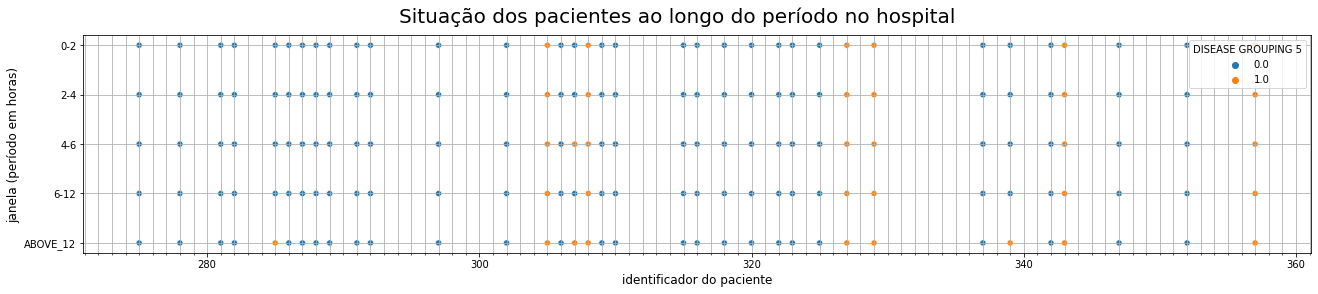

In [5]:
plt.figure(figsize=(22,4))
ax = sns.scatterplot(data=data.query('WAS_ICU==1').iloc[725:900], x='PATIENT_VISIT_IDENTIFIER', y='WINDOW', hue='DISEASE GROUPING 5')

plt.suptitle('Situação dos pacientes ao longo do período no hospital', size=20)
plt.ylabel('janela (período em horas)', size=12)
plt.xlabel('identificador do paciente', size=12)

ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.grid()
plt.grid(which='minor')

Novamente, para melhor visualização e evitar vários gráficos, não será mostrado todos os pacientes e todas as doenças. Mas com a parte mostrada é possível ver que 2 pacientes (de identificação 285 e 339) apresentaram o tipo 5 de doença somente após 12h no hospital. Isso pode significar duas coisas: ou o paciente desenvolveu a doença enquanto estava no hospital ou então só foi descoberto que ele possuia a doença após 12h que ele havia chegado.  

Há também o paciente de identificação 307, que inicialmente não apresentava doença, no período entre 4 a 6 horas passou a apresentar, voltou com identificação zero e por último no período acima de 12 horas, voltou a ser identificado com a doença. Novamente, pode ser um erro no cadastro dos dados ou então uma doença que muda muito rápido no corpo humano. Não possuimos dados o suficiente para tirar maiores conclusões. 

Poderia ser levantado a hipótese de que os pontos onde `ICU = 0` seriam, na verdade, dados nulos. Mas ao se verificar dados nulos na faixa que estamos analisando, não há nada encontrado:

In [6]:
data['DISEASE GROUPING 5'].iloc[725:900].isnull().sum()

0

#### conclusão:

Podemos afirmar que certos pacientes foram registrados como desenvolvendo doença após a entrada do hospital, mas não se pode saber ao certo se isso foi real ou um erro na entrada de dados, já que o objetivo do Sírio Libanês não é estudar a possibilidade de pacientes desenvolverem doença dentro do hospital.

Para nossa análise de modelo, consideraremos qualquer doença apresentada em **qualquer período** do paciente no hospital. Ou seja, independente se o paciente foi registrado apresentando a doença em somente uma janela de tempo ou durante todo o seu tempo no hospital, será considerado o dado que ele **apresentou, em algum momento em que esteve no hospital**, aquela doença.

## 3) Dentre os pacientes internados, qual a média dos dados que o paciente apresentou antes dele ter ido para a UTI?

Agora queremos concentrar toda a informação dos pacientes em uma linha para cada paciente. Como foi acabado de ser abordado, dados sobre o diagnóstico de doenças serão tratados da seguinte maneira: se em algum momento da janela o paciente apresentou a doença, a linha contendo informação desse paciente receberá valor `1` na coluna correspondente à doença. A mesma lógica será aplicada para os outros tipos de dados categóricos (está se assumindo que as colunas `AGE_ABOVE65`, `AGE_PERCENTIL` e `GENDER` não mudam de valor ao longo da janela). Por fim, lembramos que a mesma lógica também foi usada com a coluna `ICU`, quando foi criada a coluna `WAS_ICU`.

Mas e quanto aos dados contínuos, que representam exames de sangue e sinais vitais? A média entre esses valores para cada paciente parece ser uma boa medida para representar os dados de uma única maneira. **Um lado negativo dessa estratégia** é que pacientes que mudaram os resultados de seus exames rapidamente durante seu tempo no hospital podem ser mal representados. Mas para simplificar o trabalho, sem deixar de procurar usar o máximo de dados fornecidos pelo Sírio Libanês, vamos tratar somente com a média. Uma sugestão de um método mais sofisticado seria criar além da média uma nova coluna com o desvio padrão dos valores de cada um dos dados contínuos.

Para fazermos a média encontramos 2 problemas:

1 - há muitos dados nulos que precisam ser preenchidos. Precisa ser desenvolvido um método para esse preenchimento.

2 - por orientação do Sírio Libanês, não podemos usar os dados de pacientes que já foram internados. Ou seja, não podemos usar dados de nenhuma linha aonde `ICU = 1`.

Para resolver o primeiro problema, vamos usar a estratégia sugestionada pelo próprio Sírio Libanês. Vamos preencher os dados faltantes com os mesmos valores apresentados nas janelas posteriores ou anteriores à janela onde o dado falta. No nosso caso, vamos preencher primeiramente os dados com valores das janelas anteriores e os dados nulos que faltarem serão preenchidos com os valores das janelas posteriores. O que fará isso será a função `fill_nan` e `fill_data`.

Mas o problema 2 também nos diz que não podemos usar dados das linhas aonde `ICU = 1`. Isso obriga a não usarmos o método descrito no parágrafo acima com dados de pacientes que já tinham sido internados. Isso provavelmente fará com que ainda restem muitos dados nulos. Esses últimos serão excluídos do dataframe.

Resolvidos os 2 problemas, por fim precisamos resumir os dados de cada paciente conforme explicado anteriormente. O que fará isso será a função `prepare_data`.

In [7]:
def fill_nan(rows):
  rows.loc[rows['ICU'] == 0] = rows.loc[rows['ICU'] == 0].fillna(method='ffill').fillna(method='bfill')
  return rows

def fill_data(data):
  # preenche dados faltantes com dados das janelas posteriores
  features_continue_col = data.iloc[:, 13:-3].columns.to_list()
  features_continue_col.append('ICU')
  features_continue = data.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continue_col].apply(fill_nan)
  features_continue.drop('ICU', axis=1, inplace=True)
  features_categorical = data.iloc[:, :13]
  window_and_icu = data.iloc[:, -3:]
  final_data = pd.concat([features_categorical, features_continue, window_and_icu], ignore_index=True, axis=1)
  final_data.columns = data.columns
  return final_data

clean_data = fill_data(data)
clean_data.shape

(1925, 232)

In [8]:
# retirando dados nulos:
clean_data = clean_data.dropna()
clean_data.shape

(1555, 232)

In [9]:
def prepare_data(rows):
  # verificando se o paciente foi internado na primeira janela de tempo
  # não podemos usar os dados desses pacientes
  if (any(rows.loc[rows['WINDOW'] == '0-2']['ICU'])):
    return None
  else:
    # tratando os dados contínuos com a média somente dos dados válidos
    for col in rows.iloc[:, 13:-3].columns:
      rows.loc[rows['WINDOW'] == '0-2'][col] = rows.loc[rows['ICU'] == 0][col].mean()

    # tratando os dados categóricos
    for col in rows.iloc[:,1:13].columns:
      if (np.any(rows[col]) == 1):
        rows.loc[rows["WINDOW"]=="0-2", col] = 1
    return rows.loc[rows['WINDOW'] == '0-2']
  
clean_data = clean_data.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_data)
clean_data.drop('PATIENT_VISIT_IDENTIFIER', axis=1, inplace=True)

In [10]:
# verificando quantas linhas do dataframe restaram
clean_data.tail()

,,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,WAS_ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
380,1900,0,40th,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.293564,-0.293564,-0.293564,...,-1.0,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.160494,-0.692308,0.339623,-0.448276,0.142857,0.736842,0.030928,-0.375,0.401709,-0.357143,0.472527,0.898990,-0.418803,-0.783784,0.059701,-0.515152,-0.072464,0.736842,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,0-2,0,1
381,1905,1,Above 90th,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-1.0,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,-0.407407,-0.692308,-0.283019,-0.448276,-0.250000,0.526316,-0.175258,-0.375,-0.162393,-0.357143,0.230769,0.818182,-0.589744,-0.783784,-0.432836,-0.515152,0.072464,0.526316,-1.0,-1.0,-1.0,-1.0,-0.619048,-1.0,-1.0,-1.0,-1.0,-1.0,-0.612627,-1.0,0-2,0,0
382,1910,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-1.0,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,0.012346,-0.384615,-0.320755,-0.448276,-0.071429,0.894737,0.175258,-0.125,-0.196581,-0.357143,0.340659,0.959596,-0.299145,-0.567568,-0.462687,-0.515152,-0.246377,0.894737,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,0-2,0,1
383,1915,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-1.0,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,0.086420,-0.230769,-0.301887,-0.655172,-0.107143,0.736842,0.237113,0.000,-0.179487,-0.571429,0.318681,0.898990,-0.247863,-0.459459,-0.447761,-0.696970,-0.275362,0.736842,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,0

Como foi analisado, realmente muitos dados tiveram que ser excluídos. Inicialmente, tínhamos **385** pacientes conforme mostra `PATIENT_VISIT_IDENTIFIER` (a identificação zero precisa ser contada também). Agora, com o tratamento dos dados, restaram **294** pacientes. Com essa redução de pacientes, é bom olharmos de novo para a porcentagem de pessoas que foram ou não para a UTI:

In [11]:
x = clean_data['WAS_ICU'].value_counts(normalize=True) * 100
print(f'Porcentagem de pacientes internados: {x[1]:.2f}%')
print(f'Porcentagem de pacientes que não precisaram ir a UTI: {x[0]:.2f}%')

Porcentagem de pacientes internados: 35.71%
Porcentagem de pacientes que não precisaram ir a UTI: 64.29%


#### conclusão:
agora no dataframe cada coluna de dados contínuos possui a **média válida** do paciente e nenhum dado de paciente que já tinha sido internado na UTI foi usado.

## 4) qual a diferença que o paciente ter ou não determinado tipo de doença faz no resultado dele ter sido internado ou não?

Responder essa pergunta ficou mais fácil depois de ter os dados decada paciente resumidos em uma única linha. Resolveremos a questão **visualmente** com gráficos de barras. Basta fazermos a contagem de pacientes que foram internados e os que não e dividir esses dois grupos entre os que apresentavam determinado tipo de doença e os que não.

Lembrando que `HTN` representa hipertensão, valor `0` é para ausência da doença e valor `1` é para paciente com a doença. Além disso, ressaltamos que o valor `1` significa que em **pelo menos** algum momento o paciente apresentou a doença **antes** de ser internado.

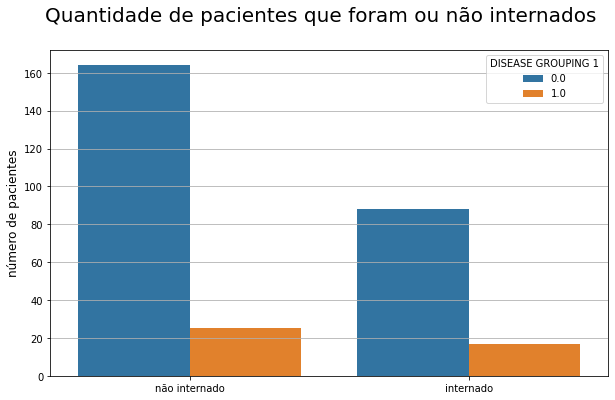

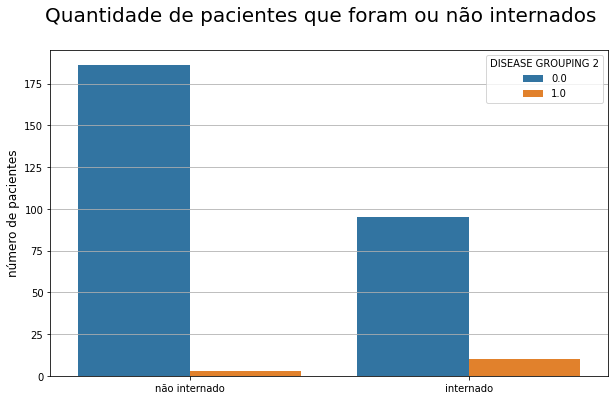

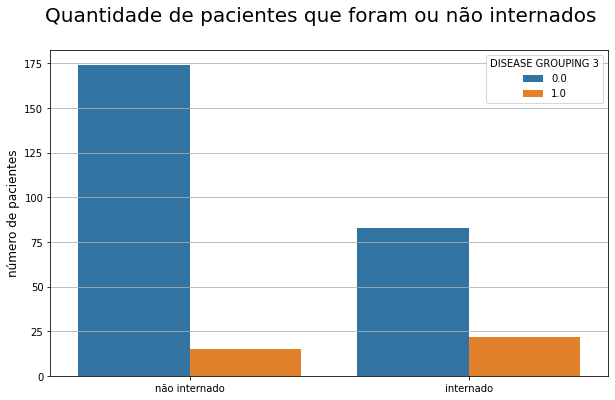

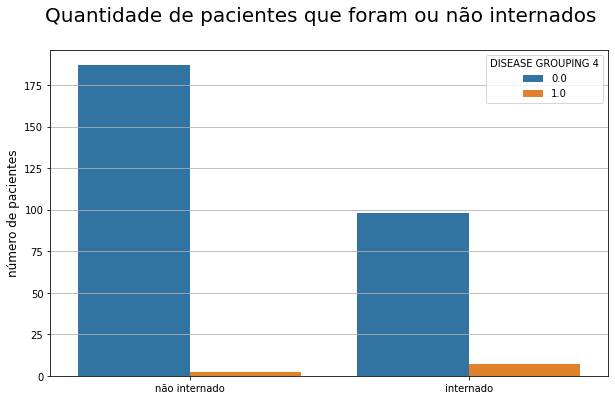

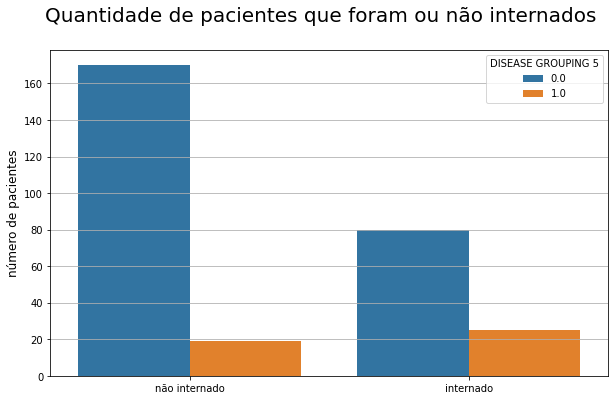

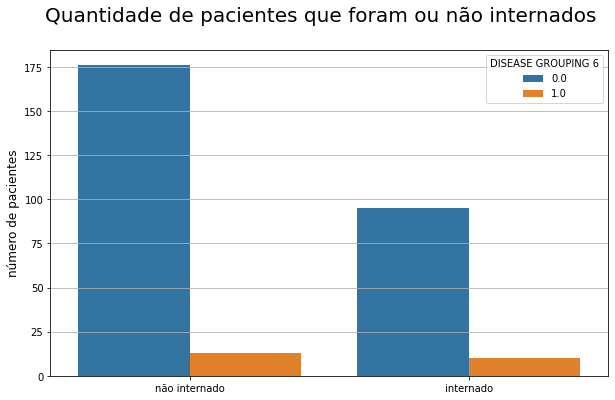

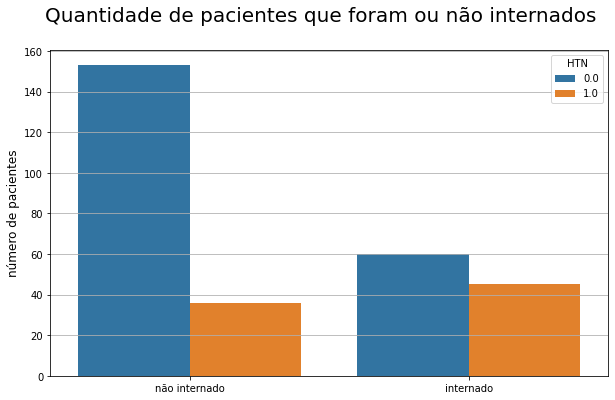

In [12]:
def plot_count_bar_hue(data, hue_col):
  plt.figure(figsize=(10,6))

  ax = sns.countplot(data=data, x='WAS_ICU', hue=hue_col)
  plt.suptitle('Quantidade de pacientes que foram ou não internados', size=20)
  
  plt.xlabel('')
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(['não internado', 'internado']))
  plt.ylabel('número de pacientes', size=12)
  plt.grid(axis='y')
  plt.show()

for col in clean_data.loc[:,'DISEASE GROUPING 1':'HTN'].columns.tolist():
  plot_count_bar_hue(clean_data, col)

Para ser verificado uma alta relação direta entre a doença e o diagnóstico do paciente, se ele precisou ou não ser internado, o que deveríamos ver é uma barra azul bem alta entre os não internados e uma barra laranja bem alta entre os internados. O primeiro caso mostra que o fato de alguém **não ter a doença** influencia nela **não ser** internada, enquanto que o segundo caso mostra que o fato da pessoa **ter a doença** influencia nela **ser** internada. Esse parece ser o caso da doença de tipos 3, 5 e a hipertensão.

Outra coisa que podemos comparar é os dados entre as pessoas que possuem a doença. Se houve mais pacientes diagnosticados precisando de UTI, então talvez seja mais provável que o fato de alguém ter esse tipo de doença **determine** que ele vai para a UTI. Vejamos os gráficos com somente pacientes que apresentaram os tipos de doença:

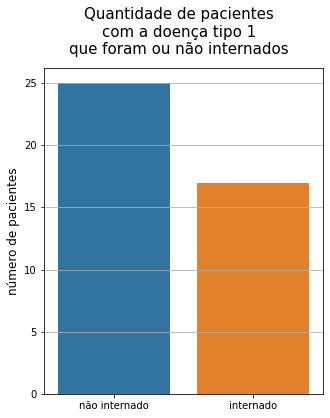

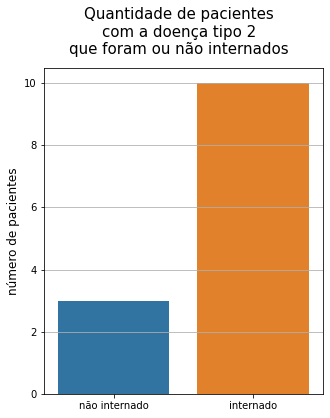

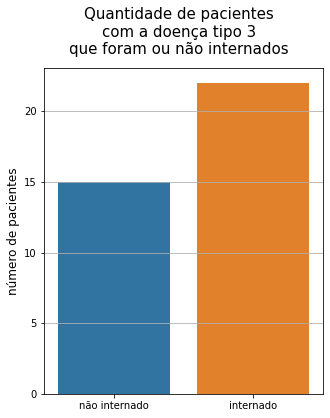

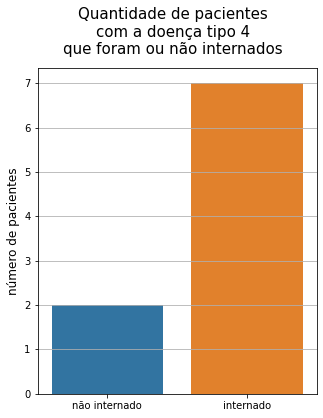

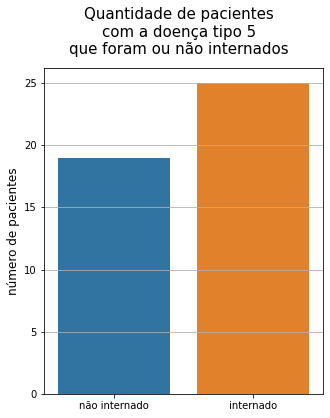

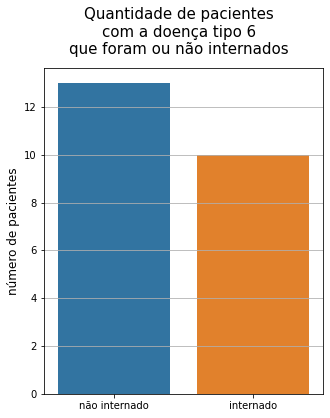

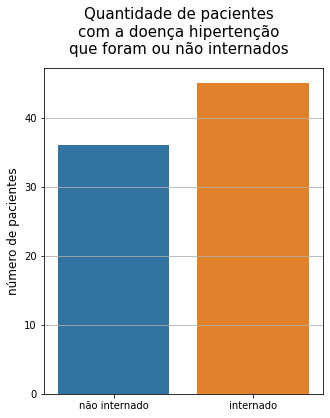

In [13]:
def plot_count_bar(data, col_query):
  disease_dic = {'DISEASE GROUPING 1':'tipo 1', 'DISEASE GROUPING 2':'tipo 2', 'DISEASE GROUPING 3':'tipo 3', 
                 'DISEASE GROUPING 4':'tipo 4', 'DISEASE GROUPING 5':'tipo 5', 'DISEASE GROUPING 6':'tipo 6', 
                 'HTN':'hipertenção'}
  plt.figure(figsize=(5,6))

  ax = sns.countplot(data=data.loc[data[col_query] == 1,:], x='WAS_ICU')
  title = 'Quantidade de pacientes\ncom a doença ' + disease_dic[col_query] + '\nque foram ou não internados'
  plt.suptitle(title, y=1.02,size=15)
  
  plt.xlabel('')
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(['não internado', 'internado']))
  plt.ylabel('número de pacientes', size=12)
  plt.grid(axis='y')
  plt.show()

for col in clean_data.loc[:,'DISEASE GROUPING 1':'HTN'].columns.tolist():
  plot_count_bar(clean_data, col)

Além das doenças de tipo 3, 5 e a hipertensão, que já foram destacadas, chama atenção a diferença entre as barras nas doenças de tipo 2 e 4. Porém, observando a escala, vemos uma pequena diferença na quantidade de pacientes. A doença de tipo 2 teve 7 pacientes a mais internados (comparado aos que não foram) e a de tipo 4 teve 5 pacientes a mais na UTI.

#### conclusão:

Apesar dos gráficos nos dizerem alguma coisa, é difícil afirmar o quanto determinada doença influencia no diagnóstico de um paciente ir não ou não para a UTI. Mesmo que fosse aplicado testes estatísticos, eles não dariam muito resultado significativo porque o número de pacientes nos dados é baixo.

É importante ressaltar que a análise feita aqui é bastante superficial e não considera o impacto que uma determinada doença causa **em conjunto com outra**. Às vezes, uma determinada doença sozinha não causa um agravamento no quadro de um paciente, mas essa doença dentro de um conjunto de outras doenças pode causar muito risco a alguém.

## 5) Pacientes imunocomprometidos correm alto risco de serem internados?

Podemos fazer a mesma análise feita com as doenças, mas agora separando pacientes pelos dados da coluna `IMMUNOCOMPRISED`.

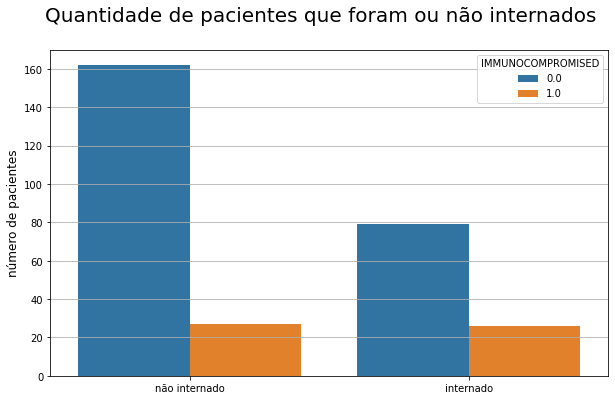

In [14]:
plot_count_bar_hue(clean_data, 'IMMUNOCOMPROMISED')

Em um primeiro momento, podemos pensar que o fato do paciente ser imunocomprometido não determina muito se ele será internado ou não. Isso porque as barras laranjas possuem um tamanho muito próximo, ou seja, a quantidade de pacientes imunocomprometidos que foram internados é próxima a dos que não foram. Mas devemos nos lembrar que a porcentagem do total de pacientes de pessoas que não foram internadas é maior do que as que não foram. O que deve ser observado é a **proporção** de pessoas imunocomprometidas diante dos pacientes em cada caso: dos que foram internados e os que não foram. Vamos fazer esses cálculos:

In [15]:
clean_data.query('WAS_ICU == 1' and 'IMMUNOCOMPROMISED == 1')['WAS_ICU'].shape[0] / clean_data.query('WAS_ICU == 1')['WAS_ICU'].shape[0]

0.5047619047619047

In [16]:
p_icu = clean_data.query('WAS_ICU == 1' and 'IMMUNOCOMPROMISED == 1')['WAS_ICU'].shape[0] / clean_data.query('WAS_ICU == 1')['WAS_ICU'].shape[0] * 100
p_not_icu = clean_data.query('WAS_ICU == 0' and 'IMMUNOCOMPROMISED == 1')['WAS_ICU'].shape[0] / clean_data.query('WAS_ICU == 0')['WAS_ICU'].shape[0] * 100

print(f'porcentagem de pacientes imunocomprometidos dentre os que foram internados: {p_icu:.2f}%')
print(f'porcentagem de pacientes imunocomprometidos dentre os que NÃO foram internados: {p_not_icu:.2f}%')

porcentagem de pacientes imunocomprometidos dentre os que foram internados: 50.48%
porcentagem de pacientes imunocomprometidos dentre os que NÃO foram internados: 28.04%


Em outras palavras, estamos dizendo o seguinte: se escolhêssemos aleatoriamente um paciente dentre os que foram internados, teríamos 50,48% de chance de encontrarmos um imunocomprometido. Se fizéssemos o mesmo experimento com os que não foram internados, teríamos apenas 28,04% de chance de encontrar um imunocomprometido, uma probabilidade bem menor.

#### conclusão:

O fato do paciente se encontrar com as defesas do organismo comprometidas influencia sim em determinar se ele precisará ir no hospital ou não. Lembramos que os dados analisados nos gráficos são de **antes** do paciente saber se iria ou não para a UTI, o que torna o resultado mais condizente com a proposta de predição.

## Conclusões Finais:

Com uma análise feita dos dados, terminamos com os seguintes resultados:

1 - um dataset com os dados válidos para seguir com o trabalho e fazer um modelo de predição.

2 - juntar as informações de cada paciente em uma única linha tentando aproveitar ao máximo as informações passadas pelo Sírio Libanês.

3 - algumas conclusões sobre a influência de doenças sobre o diagnóstico do paciente precisar ir ou não para a UTI, sendo algumas de destaque a doença de tipo 2 ao 5 e a hipertensão.

4 - verificamos também que é bastante considerável a possibilidade de se encontrar um paciente imunocomprometido dentre os que foram internados.

É importante destacar que nos dados finais, a porcentagem de pacientes diagnosticados indo para a UTI caiu bastante, de 50.65% para 35.71%. Isso pode influenciar negativamente na construção do modelo.

# Exportando dados para o notebook de desenvolvimento de modelo:

In [17]:
clean_data.to_csv('clean_data_out.csv')